This notebook compares distributions in control regions and signal regions between tuned results, results from ATLAS analysis and the observed data. Generator and detector parameters are tuned by using only control regions, then the tuned parameters are used to generate MC events for such comparison.

In [1]:
import yoda
from __future__ import print_function
from future.utils import iteritems
from future.utils import itervalues
from future.utils import iterkeys

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def make_ploter(input_dir_, samples, analysis):
    # read yoda files
    input_dir = os.path.join('inputs', input_dir_)
    data_dict = {}
    for sample in samples:
        file_name = os.path.join(input_dir, sample, 'submit', '000000', 'combined.yoda')
        data = yoda.read(file_name)
        data_dict[sample] = data
        
    data_name = analysis+'.yoda'
    ref_data = yoda.read(os.path.join(input_dir, data_name))
    
    # define some ploting styles
    #COLORS = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    COLORS = ["steelblue", "darkorange", "forestgreen", "firebrick", "darkviolet", "saddlebrown", "plum", 'darkgrey']
    LSTYLES = ['solid']*10
    
    plotkeys = {
        "xlabel": "",
        "ylabel": "Events / Bin",
        "logY": True,
        "title": r"new physics search in mono-jet channel",
        'LegendFontSize': 'large'
    }
    
    def ploter(name, xaxis_label=" ", logY=False, out_file_name='test', y_limis=(1e-3, 1e4), add_MC=True):
        hist_name = '/'+analysis+'/'+name
        #sort samples according to their area
        sorted_samples = []
        results = []
        for ip,sample in enumerate(samples):
            hist = data_dict[sample][hist_name]
            
            hist.setAnnotation('linecolor', COLORS[ip])
            hist.setAnnotation('linestyle', LSTYLES[ip])
            hist.setAnnotation('Title', sample)
            hist.setAnnotation('line', 'bar')
            hist.setAnnotation('nEvents', hist.integral())
            results.append(hist.integral())

            if hist.integral() < 1e-5:
                continue
            else:
                pass
                
            if len(sorted_samples) == 0:
                sorted_samples.append(sample)
            else:
                #temp_samples = sorted_samples
                for ipushed, pushed in enumerate(sorted_samples):
                        
                    ipushed_hist = data_dict[pushed][hist_name]
                    if hist.integral() <= ipushed_hist.integral():
                        # print(sample," will be inserted to ", ipushed)
                        sorted_samples.insert(ipushed, sample)
                        break
                    elif ipushed == len(sorted_samples) - 1:
                        sorted_samples.append(sample)
                        break
                    else:
                        pass
                    
        
        # print(name, "selected samples: ", ",".join(sorted_samples))
        stacked_plots = []
        for ip,sample in enumerate(sorted_samples):
            hist = data_dict[sample][hist_name].clone()
            next_ip = ip - 1
            while next_ip >= 0:
                hist += data_dict[sorted_samples[next_ip]][hist_name]
                next_ip -= 1

            # hist.setAnnotation('Path', hist.annotation('Path')+"_"+sample)
            stacked_plots.insert(0, hist)

        results.append(stacked_plots[0].integral())
        
        ref_hist = ref_data['/REF'+hist_name].clone()
        ref_hist.setAnnotation('linecolor', 'black')
        ref_hist.setAnnotation('line', None)
        ref_hist.setAnnotation('errorbars', True)
        ref_hist.setAnnotation('errorbarscolor', 'black')
        ref_hist.setAnnotation('Title', 'Data')
        ref_sum = sum([p.y*(p.xMax-p.xMin) for p in ref_hist.points])
        ref_hist.setAnnotation("nEvents", ref_sum)
        results.append(ref_sum)
        stacked_plots.insert(0, ref_hist)
        
        if add_MC:
            mc_hist = ref_data['/REF'+hist_name.replace('y01', 'y02')].clone()
            mc_hist.setAnnotation('marker', 's')
            mc_hist.setAnnotation('linecolor', 'magenta')
#             mc_hist.setAnnotation('errorbars', True)
#             mc_hist.setAnnotation('errorbarscolor', 'black')
            mc_hist.setAnnotation('Title', 'MC.Ref')
            mc_sum = sum([p.y*(p.xMax-p.xMin) for p in mc_hist.points])
            mc_hist.setAnnotation("nEvents", mc_sum)
            stacked_plots.insert(0, mc_hist)
        

        plotkeys['xlabel'] = xaxis_label
        plotkeys['logY'] = logY
        plotkeys['ymin'] = y_limis[0]
        plotkeys['ymax'] = y_limis[1]
        out = os.path.join('output', input_dir_)
        if not os.path.exists(out):
            os.makedirs(out)
        out = os.path.join(out, out_file_name+'.pdf')
        fig, (axmain, axratio) = yoda.plot(stacked_plots, outfile=out, ratio=False, **plotkeys)
        return results

    return ploter

In [3]:
processes = [
    ['Wmunu',  '50k'],
    ['Wenu',   '50k'],
    ['Wtaunu', '50k'],
    ['Zmumu',  '50k'],
    ['Ztautau', '50k'],
    ['Zvv', '50k'],
    ['ttbar', '1M'],
    ['vv', '1M']
]

In [16]:
input_dir = 'SamplesWithTunedParametersFromV3AddSmearing'

In [17]:
samples = [x[0] for x in processes]
print(samples)

['Wmunu', 'Wenu', 'Wtaunu', 'Zmumu', 'Ztautau', 'Zvv', 'ttbar', 'vv']


In [18]:
xaxis_renames = {
    'd01-x01-y01': ['$W \\rightarrow \\mu\\nu$, $E_{T}^{miss}$ [GeV]', True, 'wmunu_met'],
    'd02-x01-y01': ['$W \\rightarrow \\mu\\nu$, leading jet $pT$ [GeV]', True, 'wmunu_pT'],
    'd03-x01-y01': ['$W \\rightarrow e\\nu$, $E_{T}^{miss}$ [GeV]', True, 'wenu_met'],
    'd04-x01-y01': ['$W \\rightarrow e\\nu$, leading jet $pT$ [GeV]', True, 'wenu_pT'],
    'd05-x01-y01': ['$Z \\rightarrow \\mu\\mu$, $E_{T}^{miss}$ [GeV]', True, 'Zmumu_met'],
    'd06-x01-y01': ['$Z \\rightarrow \\mu\\mu$, leading jet $pT$ [GeV]', True, 'Zmumu_pT'],
    'd07-x01-y01': ['ttbar, $E_{T}^{miss}$ [GeV]', True, 'ttbar_met'],
    'd08-x01-y01': ['ttbar, leading jet $pT$ [GeV]', True, 'ttbar_pT'],
    'd09-x01-y01': ['$E_{T}^{miss}$ [GeV]', True, 'sr_met'],
    'd10-x01-y01': ['leading jet $pT$ [GeV]', True, 'sr_pT'],
    'd11-x01-y01': ['leading jet $\\eta$ [GeV]', False, 'sr_eta'],
    'd12-x01-y01': ['$n_{jets}$ [GeV]', False, 'sr_njets']
}

In [19]:
analysis = 'ATLAS_2017_I1635274'

In [20]:
pp = make_ploter(input_dir, samples, analysis)

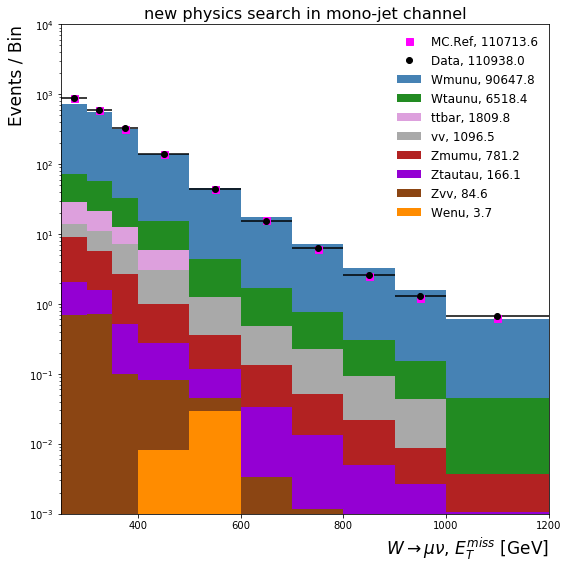

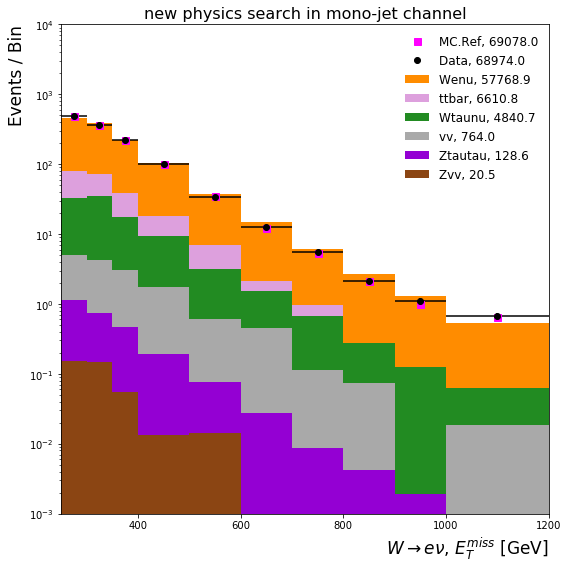

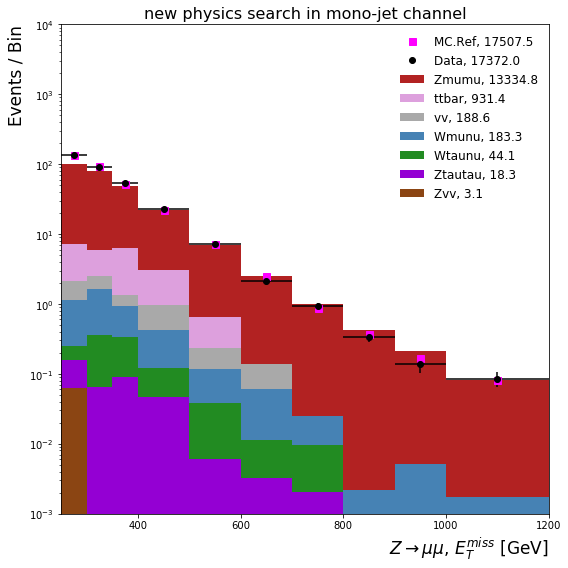

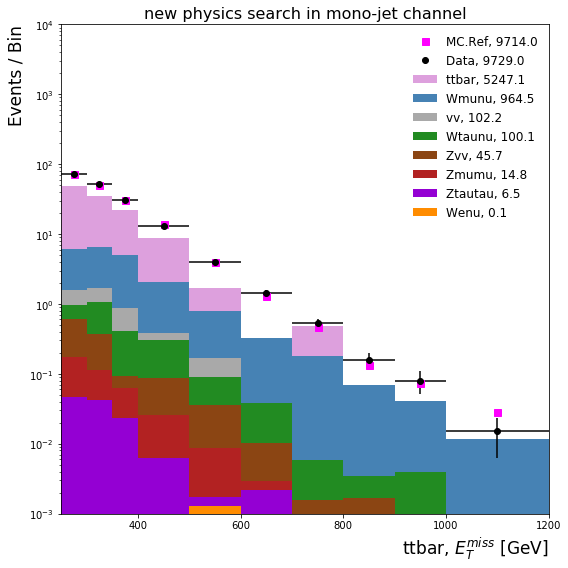

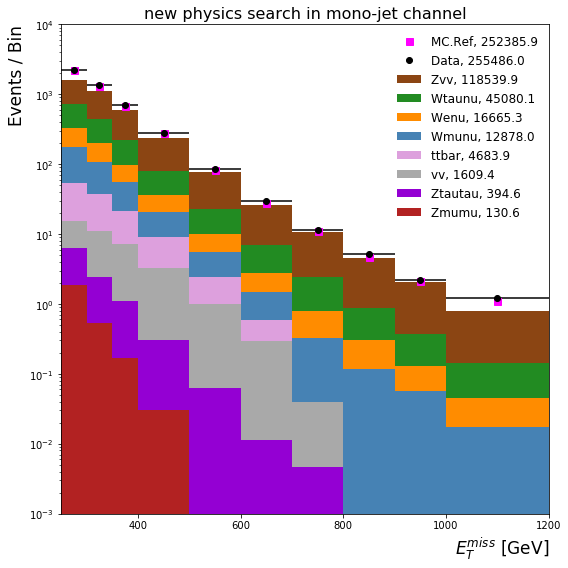

In [21]:
all_results = []
out_name = "truth"
for name in ['d01-x01-y01', 'd03-x01-y01', 'd05-x01-y01', 'd07-x01-y01', 'd09-x01-y01',]:
    logY = xaxis_renames[name][1]
    if logY:
        res = pp(name, *(xaxis_renames[name]))
    elif "d12" in name:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))
    elif "d11" in name:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 2e5))
    else:
        res = pp(name, *(xaxis_renames[name]), y_limis=(0, 4000))
    
    all_results.append(res)

In [13]:
orders = [4, 0, 2, 1, 3]
out = ""
for ip,sample in enumerate(samples):
    for order in orders:
        res = all_results[order][ip]
        out += str(res) + " "
    out += '\n'

In [14]:
print(out)

10787.31 98445.77 246.4364 11.78914 2133.787 
15407.19 2.909345 0.0 57338.66 0.0 
41693.96 6726.204 33.20708 4394.033 170.1506 
117.0192 1114.478 15226.87 0.0 43.13715 
392.6798 187.2169 23.27514 142.9392 2.998081 
118353.7 48.84247 0.0 23.87327 25.1558 
3727.736 1565.836 1084.135 5236.582 7218.791 
1567.778 1160.793 201.7231 686.5664 97.38799 



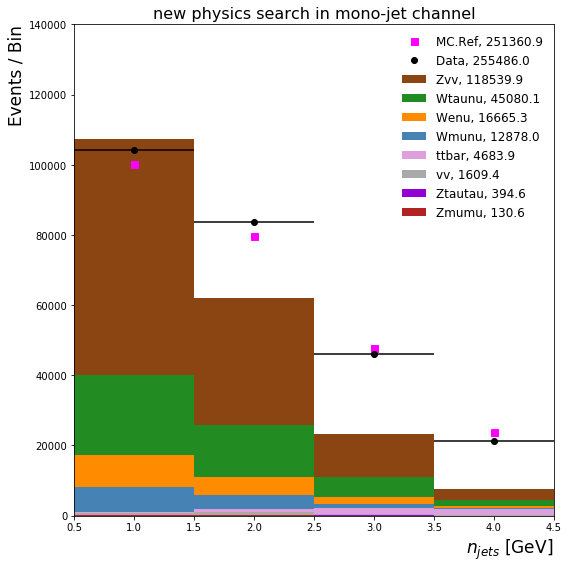

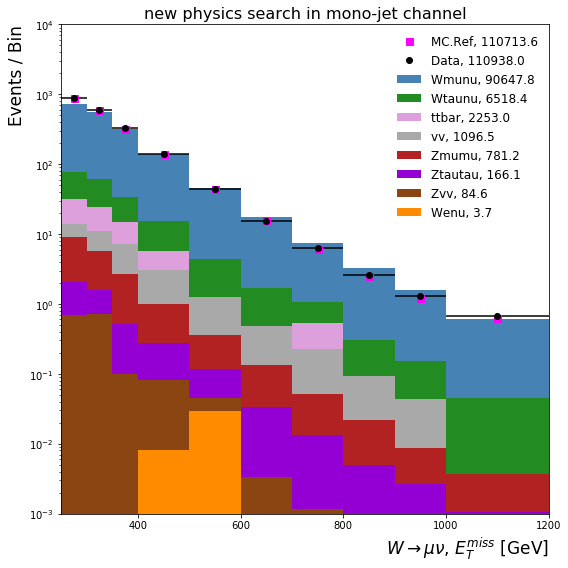

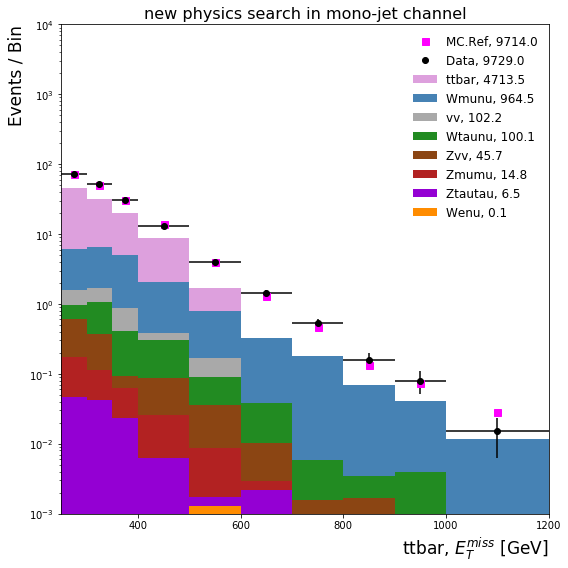

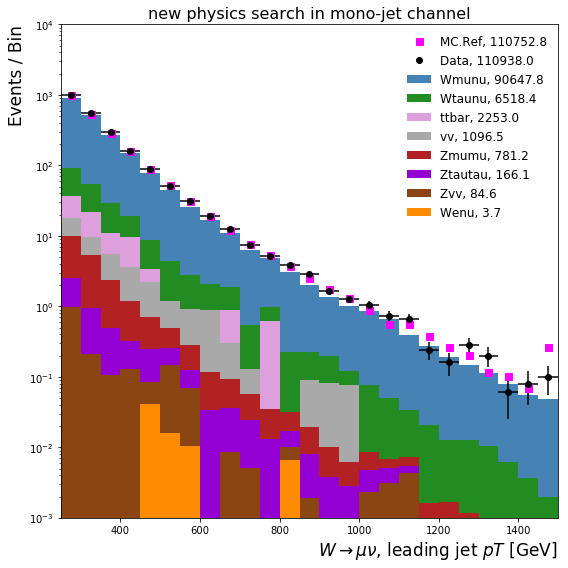

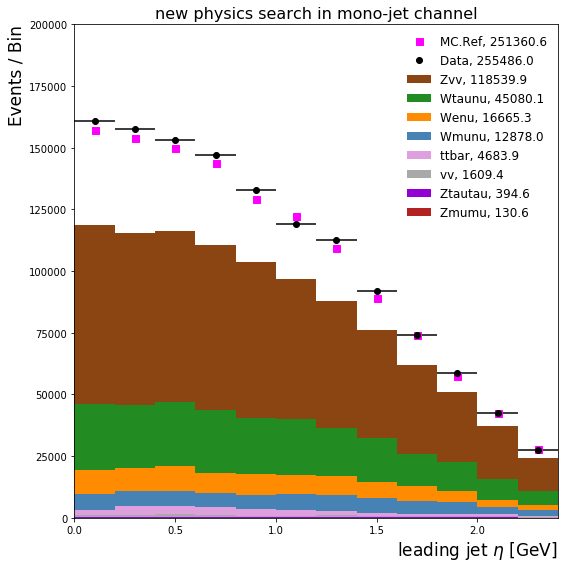

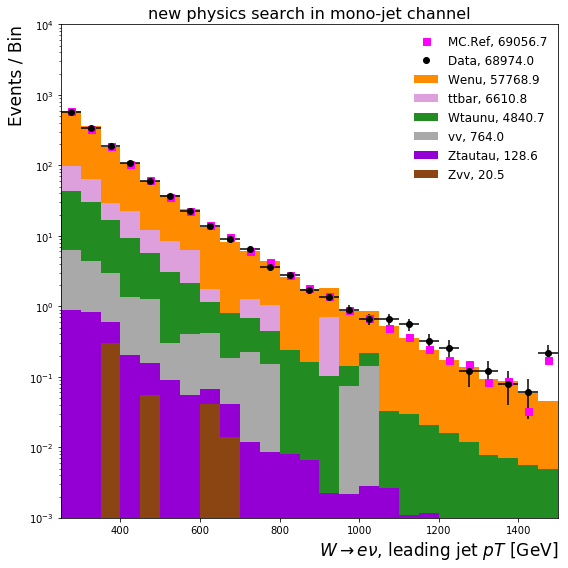

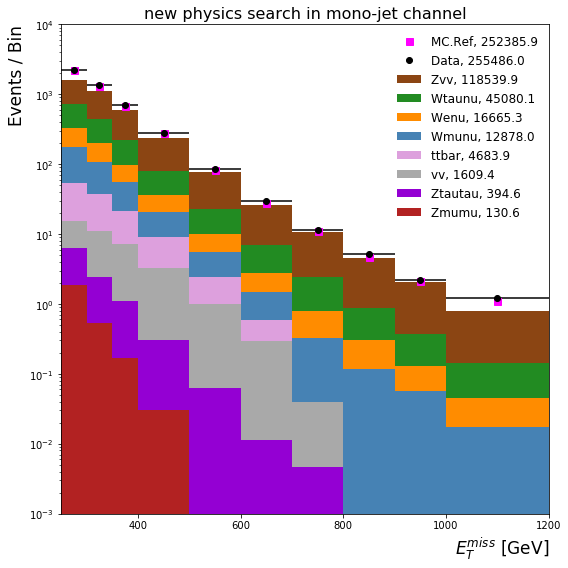

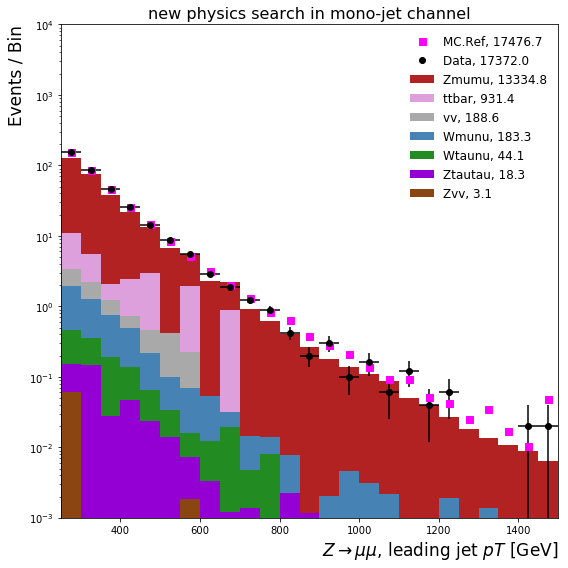

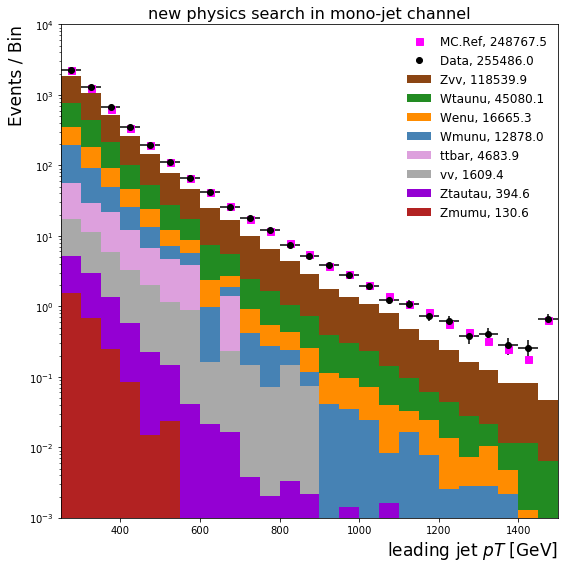

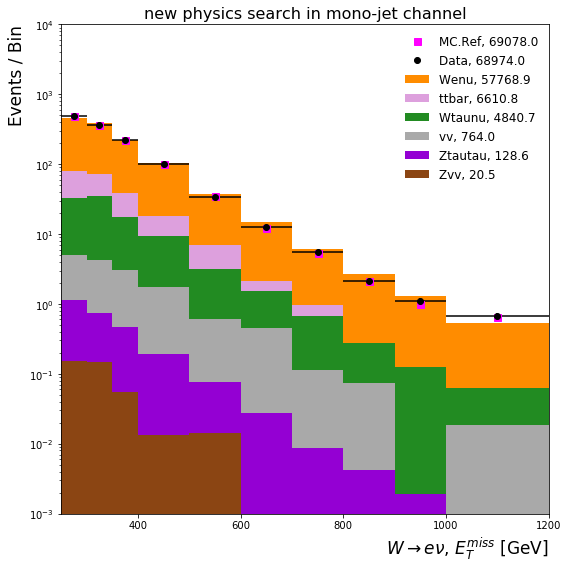

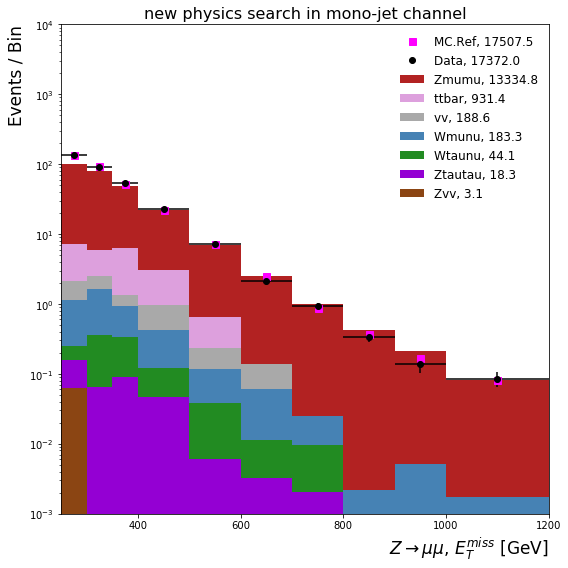

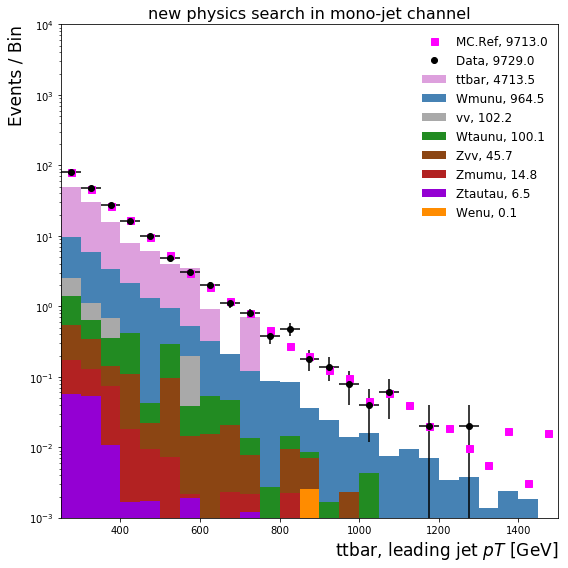

In [13]:
for name in iterkeys(xaxis_renames):
    logY = xaxis_renames[name][1]
    if logY:
        pp(name, *(xaxis_renames[name]))
    elif "d12" in name:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 1.4e5))
    elif "d11" in name:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 2e5))
    else:
        pp(name, *(xaxis_renames[name]), y_limis=(0, 4000))

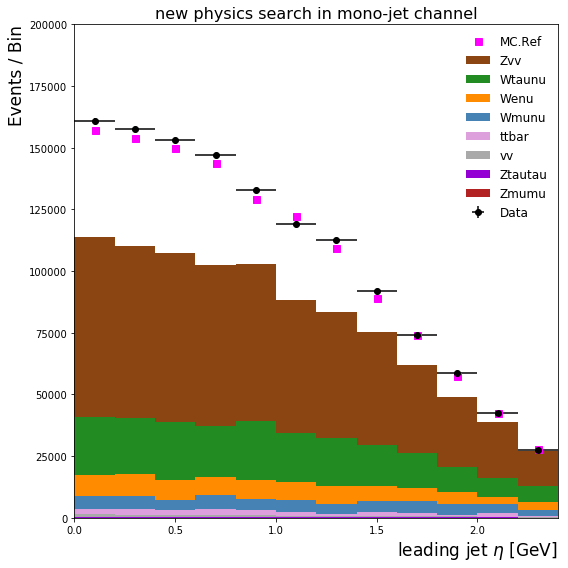

In [15]:
name = 'd11-x01-y01'
pp(name, xaxis_renames[name][0], logY=False, out_file_name=xaxis_renames[name][2], y_limis=(0, 2e5))

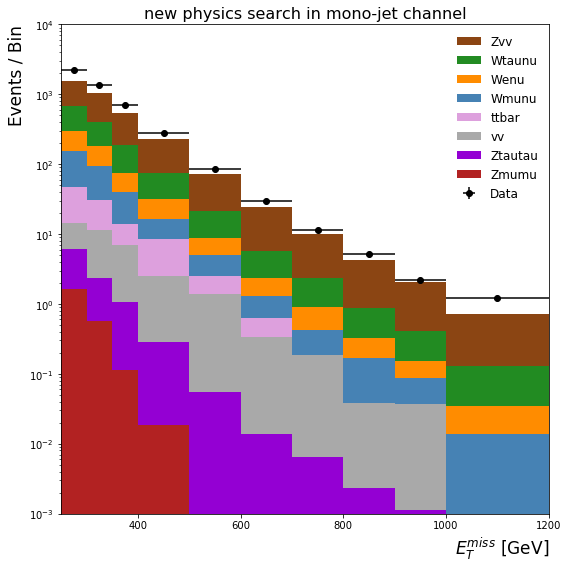

In [40]:
name = 'd09-x01-y01'
pp(name, xaxis_renames[name][0], logY=True, out_file_name=xaxis_renames[name][2])

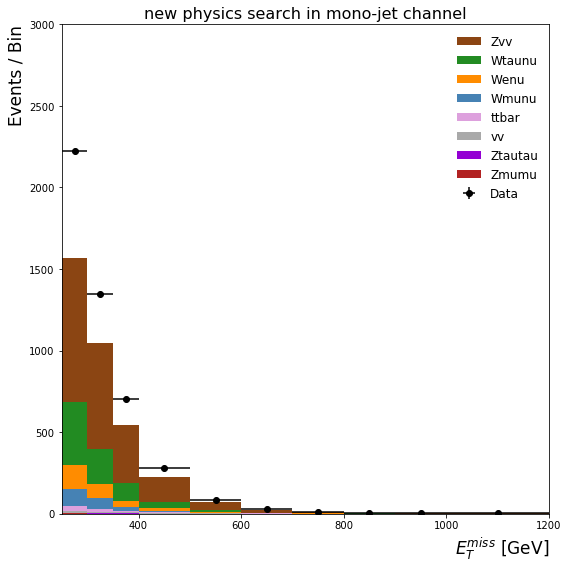

In [42]:
name = 'd09-x01-y01'
pp(name, xaxis_renames[name][0], logY=False, out_file_name=xaxis_renames[name][2], y_limis=(0, 3000))

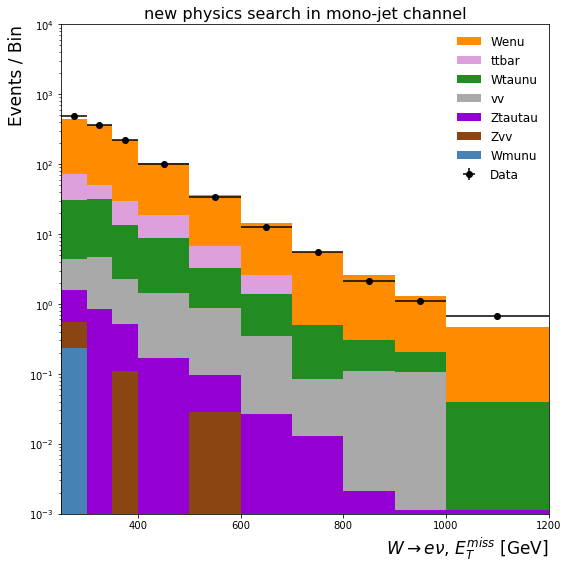

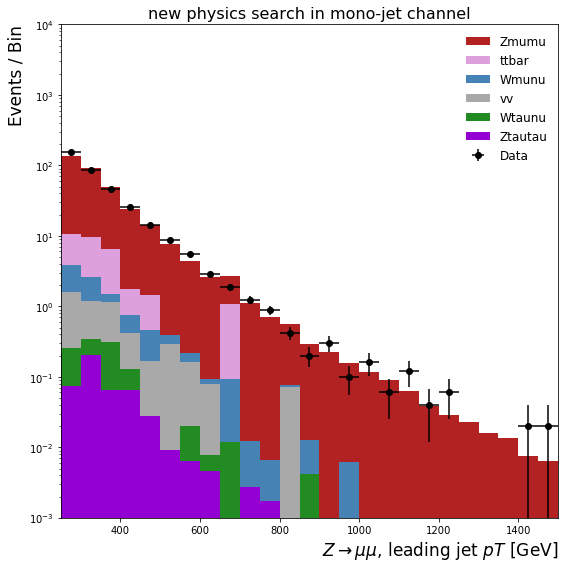

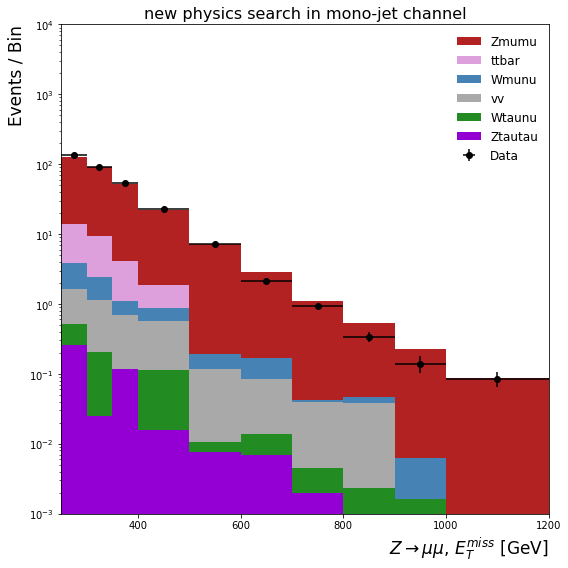

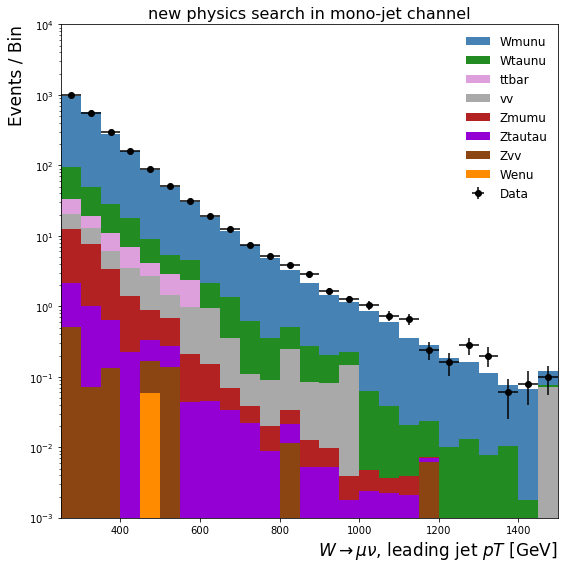

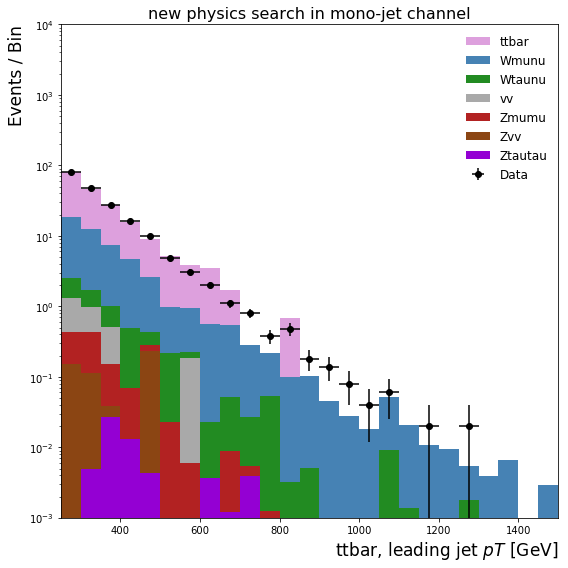

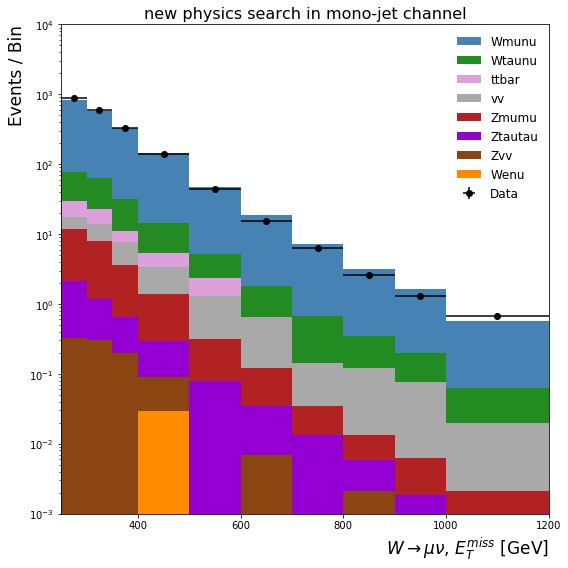

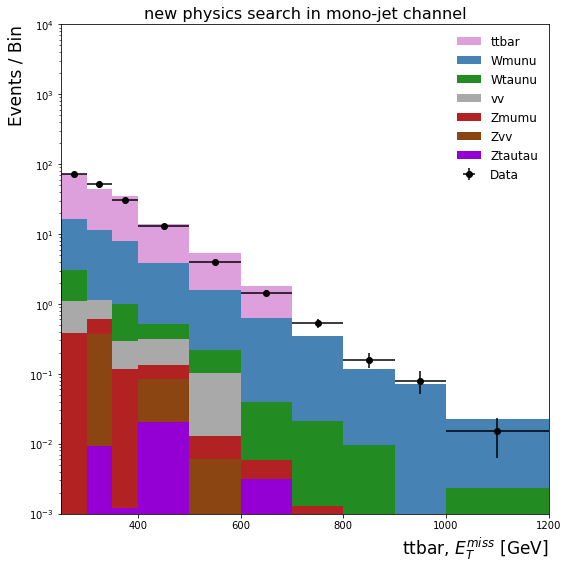

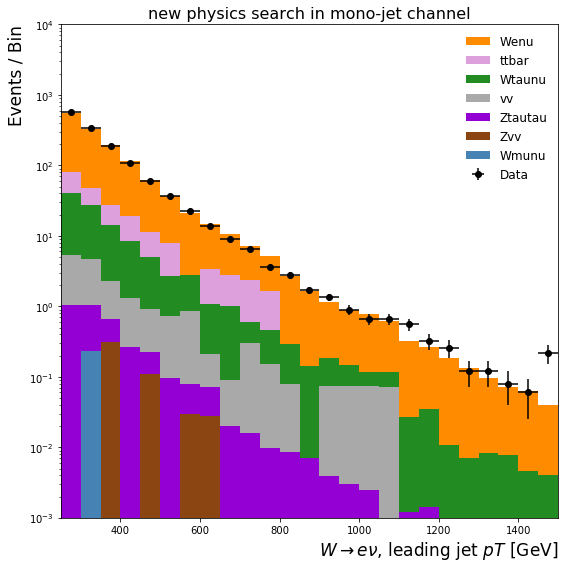

In [10]:
for name in iterkeys(xaxis_renames):
   pp(name)